In [1]:
import torch
import matplotlib.pyplot as plt
import click
import albumentations as A
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
from pathlib import Path, PosixPath
import itertools
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from dataset import BuildingSegmentation
import ray
from ray import train
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from dl_dataset import draw_mask


DEVICE_CUDA = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE_CPU = "cpu"
ENCODER = "resnet101"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "sigmoid"
PATIENCE = 5
LR_DECAY = 0.9
LR_ON_PLATEAU_DECAY = 0.1
LR_MINIMAL = 1e-5
MIN_SCORE_CHANGE = 1e-3
APPLY_LR_DECAY_EPOCH = 30

AUGMENTATIONS = [
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomScale(p=0.5),
    A.Affine(shear=20),
    A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3),
]


def generate_augmentation_combinations(augmentations):
    all_combinations = []
    for i in [1, len(augmentations) + 1]:
        combinations = itertools.combinations(augmentations, i)
        for combo in combinations:
            all_combinations.append(A.Compose(list(combo)))
    return all_combinations


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")


def get_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(A.Lambda(image=preprocessing_fn, always_apply=True))
    transform.append(A.Lambda(image=to_tensor, mask=to_tensor, always_apply=True))
    return A.Compose(transform)


def train_model(config):
    device = DEVICE_CUDA
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    if "augmentation" in config.keys():
        augmentation = config["augmentation"]
    else:
        augmentation = None
    
    train_dataset = BuildingSegmentation(
        Path(config["train_data_dir"]).joinpath("imgs"),
        Path(config["train_data_dir"]).joinpath("masks"),
        augmentation=augmentation,
        preprocessing=get_preprocessing(preprocessing_fn),
    )

    val_dataset = BuildingSegmentation(
        Path(config["val_data_dir"]).joinpath("imgs"),
        Path(config["val_data_dir"]).joinpath("masks"),
        augmentation=None,
        preprocessing=get_preprocessing(preprocessing_fn),
    )

    test_dataset = BuildingSegmentation(
        Path(config["test_data_dir"]).joinpath("imgs"),
        Path(config["test_data_dir"]).joinpath("masks"),
        augmentation=None,
        preprocessing=get_preprocessing(preprocessing_fn),
    )

    train_loader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True
    )
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(
        test_dataset, batch_size=config["batch_size"], shuffle=False
    )

    if config["use_unet"]:
        model = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            activation=ACTIVATION,
            classes=1,
        )
    else:
        model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )

    loss = smp_utils.losses.DiceLoss()
    metrics = [
        smp_utils.metrics.IoU(threshold=0.5),
        smp_utils.metrics.Accuracy(threshold=0.5),
        smp_utils.metrics.Precision(threshold=0.5),
        smp_utils.metrics.Recall(threshold=0.5),
        smp_utils.metrics.Fscore(threshold=0.5),
    ]

    optimizer_class = getattr(torch.optim, config["optimizer"])
    optimizer = optimizer_class(model.parameters(), lr=config["lr_initial"])

    train_epoch = smp_utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=device,
        verbose=False,
    )
    val_epoch = smp_utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=device,
        verbose=False,
    )

    writer = SummaryWriter()
    model_name = "unet" if config["use_unet"] else "basic"
    save_dir = f"./weights_lr_{config['lr_initial']}_bs_{config['batch_size']}_optimizer_{config['optimizer']}_{model_name}"
    Path(save_dir).mkdir(exist_ok=True)
    save_name_best = str(Path(save_dir).joinpath("best.pth"))

    min_score = 100
    min_score_epoch = 0
    best_snapshot = None
    for epoch in range(0, config["epochs"]):
        lr = optimizer.param_groups[0]["lr"]
        print(f"\nEpoch #{epoch+1} (learning rate - {lr:.2e})")

        train_logs = train_epoch.run(train_loader)
        valid_logs = val_epoch.run(val_loader)
        for metric_name, metric_value in train_logs.items():
            writer.add_scalar(f"Train/{metric_name}", metric_value, epoch)
        for metric_name, metric_value in valid_logs.items():
            writer.add_scalar(f"Validation/{metric_name}", metric_value, epoch)
        train.report(valid_logs)

        score = valid_logs["iou_score"]
        if score < min_score - MIN_SCORE_CHANGE:
            min_score = score
            min_score_epoch = epoch
            if epoch and epoch % APPLY_LR_DECAY_EPOCH == 0:
                lr *= LR_DECAY
            best_snapshot = model.state_dict().copy()
            torch.save(best_snapshot, save_name_best)

        elif min_score_epoch < epoch - PATIENCE:
            lr *= LR_ON_PLATEAU_DECAY
            min_score_epoch = epoch
        else:
            if epoch and epoch % APPLY_LR_DECAY_EPOCH == 0:
                lr *= LR_DECAY

        optimizer.param_groups[0]["lr"] = max(lr, LR_MINIMAL)

    # Load best model and evaluate
    print("\nEvaluating best model...")
    model.load_state_dict(torch.load(save_name_best, map_location=device))
    model.to(device)
    model.eval()

    logs = val_epoch.run(val_loader)
    print("Evaluation results:")
    train.report(logs)


def run_training_phase(config):
    scheduler = ASHAScheduler(
        metric="iou_score",
        mode="max",
        max_t=config["max_t"],
        grace_period=10,
        reduction_factor=2,
    )

    analysis = tune.run(
        train_model,
        config=config,
        num_samples=config["num_samples"],
        scheduler=scheduler,
        resources_per_trial={"cpu": 4, "gpu": 0.5},
    )

    print("Initial phase best config: ", analysis.get_best_config("iou_score", "max"))
    return analysis.get_best_config("iou_score", "max"), analysis.results_df


def run_augmentation_phase(best_config):

    augmentation_combinations = generate_augmentation_combinations(AUGMENTATIONS)

    best_config["augmentation"] = tune.grid_search(augmentation_combinations)
    scheduler = ASHAScheduler(
        metric="iou_score",
        mode="max",
        max_t=best_config["max_t"],
        grace_period=10,
        reduction_factor=2,
    )

    analysis = tune.run(
        train_model,
        config=best_config,
        num_samples=1,
        scheduler=scheduler,
        resources_per_trial={"cpu": 4, "gpu": 0.5},
    )

    return analysis.get_best_config("iou_score", "max"), analysis.results_df


def plot_results(
    results_df,
    name=None,
    title=None,
    filter=["config/lr_initial", "config/batch_size", "config/optimizer", "config/use_unet", "dice_loss", "iou_score", "precision", "accuracy", "recall"],
):
    # Filter the dataframe
    df_metrics = results_df[filter]

    # Round numeric values to 4 decimal places
    df_metrics = df_metrics.applymap(lambda x: round(x, 4) if isinstance(x, (int, float)) else x)
    
    # Find the best results for each metric and make them bold
    for col in ["dice_loss", "iou_score", "precision", "accuracy", "recall"]:
        if col in df_metrics.columns:
            best_value = df_metrics[col].max()
            df_metrics[col] = df_metrics[col].apply(lambda x: f"**{x}**" if x == best_value else x)
    
    # Create the plot
    _, ax = plt.subplots(figsize=(10, 6))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(
        cellText=df_metrics.values,
        colLabels=df_metrics.columns,
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(df_metrics.columns))))

    if title:
        plt.title(title, fontsize=15, pad=20)

    plt.savefig(name)


2024-07-08 18:11:40,779	INFO worker.py:1771 -- Started a local Ray instance.
2024-07-08 18:11:41,186	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_model pid=2620010) 
(train_model pid=2620010) Epoch #1 (learning rate - 1.00e-03)
(train_model pid=2620009) 


Trial name,accuracy,dice_loss,fscore,iou_score,precision,recall
train_model_c3184_00000,0.901444,0.534071,0.466794,0.305865,0.404662,0.560016
train_model_c3184_00001,0.910473,0.929855,0.25164,0.145575,0.362902,0.198895


(train_model pid=2620010) 
(train_model pid=2620010) Epoch #2 (learning rate - 1.00e-03) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_model pid=2620010) 
(train_model pid=2620010) Epoch #3 (learning rate - 1.00e-03)
(train_model pid=2620009) 
(train_model pid=2620009) Epoch #2 (learning rate - 1.00e-03)
(train_model pid=2620010) 
(train_model pid=2620010) Epoch #4 (learning rate - 1.00e-03)
(train_model pid=2620009) 
(train_model pid=2620009) Epoch #3 (learning rate - 1.00e-03)
(train_model pid=2620010) 
(train_model pid=2620010) 
(train_model pid=2620010) Epoch #6 (learning rate - 1.00e-03) [repeated 2x across cluster]
(train_model pid=2620009) 
(train_model pid=2620009) Epoch #4 (learning rate - 1.00e-03)
(train_model pid=2620010) 
(train_model pid=2620010) Epoch #7 (learning rate - 

2024-07-08 18:26:20,291	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lt/ray_results/train_model_2024-07-08_18-11-41' in 0.0084s.
2024-07-08 18:26:20,295	INFO tune.py:1041 -- Total run time: 879.11 seconds (879.08 seconds for the tuning loop).


Initial phase best config:  {'max_t': 20, 'num_samples': 1, 'epochs': 100, 'use_unet': True, 'train_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_train'), 'val_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_val'), 'test_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_test'), 'batch_size': 32, 'lr_initial': 0.001, 'optimizer': 'AdamW'}


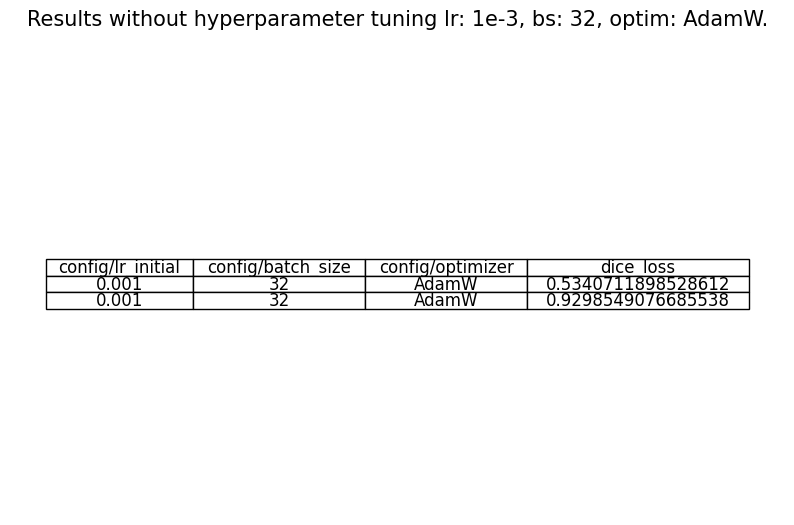

In [2]:
num_samples=1
max_epochs=100
train_data_dir="./segmentation_dataset_train"
val_data_dir="./segmentation_dataset_val"
test_data_dir="./segmentation_dataset_test"
train.RunConfig("./results")
ray.init(num_cpus=8, num_gpus=1)

no_tuning_config = {
    "max_t": 20,
    "num_samples": num_samples,
    "epochs": max_epochs,
    "use_unet": tune.grid_search([True, False]),
    "train_data_dir": Path(train_data_dir).resolve(),
    "val_data_dir": Path(val_data_dir).resolve(),
    "test_data_dir": Path(test_data_dir).resolve(),
    "batch_size": 32,
    "lr_initial": 1e-3,
    "optimizer": "AdamW",
}

best_config_no_tuning, results_df = run_training_phase(no_tuning_config)
plot_results(
    results_df,
    name="no_tuning",
    title="Results without hyperparameter tuning",
)

2024-07-08 18:26:20,497	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_model pid=2624813) 
(train_model pid=2624813) Epoch #1 (learning rate - 1.00e-03)
(train_model pid=2624808) 
(train_model pid=2624813) 
(train_model pid=2624813) Epoch #2 (learning rate - 1.00e-03) [repeated 2x across cluster]
(train_model pid=2624808) 
(train_model pid=2624808) Epoch #2 (learning rate - 1.00e-03)
(train_model pid=2624813) 
(train_model pid=2624813) Epoch #3 (learning rate - 1.00e-03)
(train_model pid=2624808) 
(train_model pid=2624808) Epoch #3 (learning rate - 1.00e-03)
(train_model pid=2624813) 
(train_model pid=2624813) Epoch #4 (learning rate - 1.00e-03)
(train_model pid=2624808) 
(train_model pid=2624808) Epoch #4 (learning rate - 1.00e-03)
(train_model pid=2624813) 
(train_model pid=2624813) Epoch #5 (learning rate - 1.00e-03)
(train_model pid=2624808) 
(train_model pid=2624808) Epoch #5 (learning rate - 1.00e-03)
(train_model pid=2624813) 
(train_model pid=2624813) Epoch #6 (learning rate - 1.00e-03)
(train_model pid=2624808) 
(train_model pid=2624808) E

Trial name,accuracy,dice_loss,fscore,iou_score,precision,recall
train_model_cf342_00000,0.891178,0.534833,0.465767,0.306944,0.380126,0.618343
train_model_cf342_00001,0.899152,0.526484,0.474318,0.312292,0.402537,0.585933
train_model_cf342_00002,0.902608,0.530723,0.470292,0.308076,0.410987,0.554324
train_model_cf342_00003,0.900757,0.535597,0.466596,0.306665,0.407825,0.562674
train_model_cf342_00004,0.893339,0.534561,0.46976,0.307956,0.388385,0.604831
train_model_cf342_00005,0.889721,0.554067,0.454374,0.294888,0.370155,0.590971
train_model_cf342_00006,0.847886,0.613123,0.415202,0.263757,0.301456,0.693084
train_model_cf342_00007,0.855546,0.61326,0.423497,0.26939,0.309086,0.678719
train_model_cf342_00008,0.806054,0.67778,0.392216,0.244241,0.260316,0.799403
train_model_cf342_00009,0.773787,0.69897,0.333286,0.201348,0.21874,0.725953


2024-07-08 22:01:30,408	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lt/ray_results/train_model_2024-07-08_18-26-20' in 0.0177s.
2024-07-08 22:01:30,421	INFO tune.py:1041 -- Total run time: 12909.92 seconds (12909.88 seconds for the tuning loop).


Initial phase best config:  {'max_t': 20, 'num_samples': 1, 'epochs': 100, 'use_unet': True, 'train_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_train'), 'val_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_val'), 'test_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_test'), 'batch_size': 32, 'lr_initial': 0.001, 'optimizer': 'AdamW'}


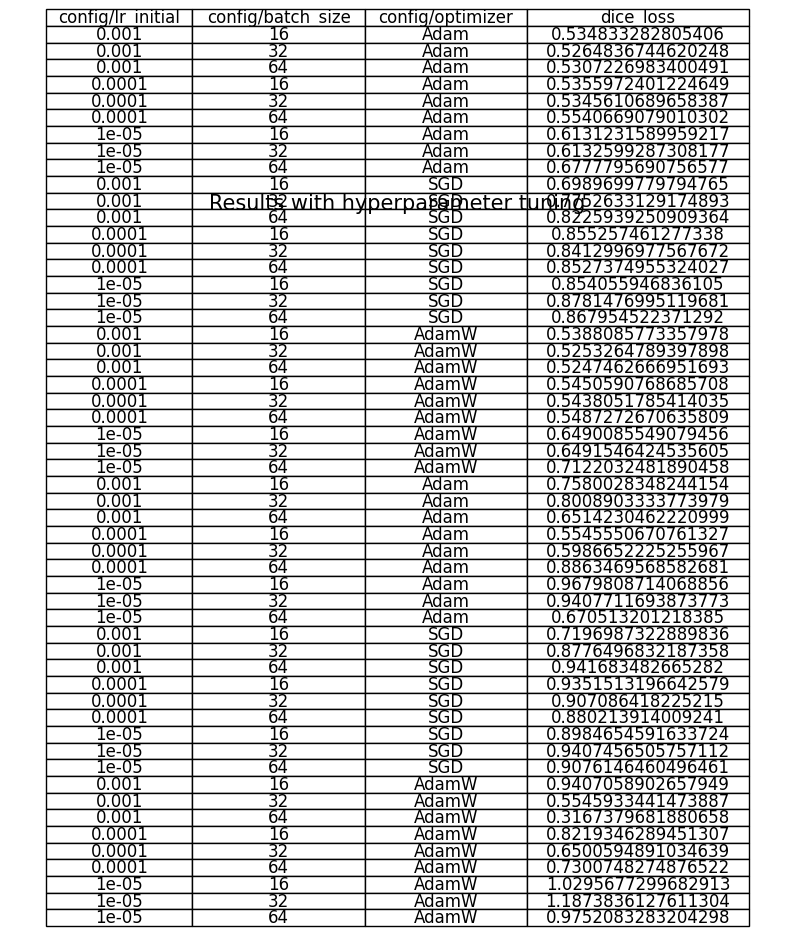

In [3]:
config = {
    "max_t": 20,
    "num_samples": num_samples,
    "epochs": max_epochs,
    "use_unet": tune.grid_search([True, False]),
    "train_data_dir": Path(train_data_dir).resolve(),
    "val_data_dir": Path(val_data_dir).resolve(),
    "test_data_dir": Path(test_data_dir).resolve(),
    "batch_size": tune.grid_search([16, 32, 64]),
    "lr_initial": tune.grid_search([1e-3, 1e-4, 1e-5]),
    "optimizer": tune.grid_search(["Adam", "SGD", "AdamW"]),
}

best_config, results = run_training_phase(config)
plot_results(results, name="tuning", title=None)

In [2]:
best_config = {'max_t': 20, 'num_samples': 1, 'epochs': 100, 'use_unet': True, 'train_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_train'), 'val_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_val'), 'test_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_test'), 'batch_size': 32, 'lr_initial': 0.001, 'optimizer': 'AdamW'}
# lower max_t here 
best_config["max_t"] = 10

best_aug_config, aug_results = run_augmentation_phase(best_config)
plot_results(
    aug_results,
    name="augmentation",
    title="Results from trying augmentation combinations.",
    filter=[
        'config/"augmentation"', "dice_loss", "iou_score", "precision", "accuracy", "recall"
    ],
)

2024-07-08 23:16:27,564	INFO worker.py:1771 -- Started a local Ray instance.
2024-07-08 23:16:28,186	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-07-08 23:16:28,188	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_model pid=2736808) 
(train_model pid=2736808) Epoch #1 (learning rate - 1.00e-03)
(train_model pid=2736800) 


Trial name,accuracy,dice_loss,fscore,iou_score,precision,recall
train_model_56ff9_00000,0.8840784671214912,0.538627516764861,0.46195176587655,0.30171964317560196,0.3630364938424184,0.6447613101739149
train_model_56ff9_00001,0.8956424330289547,0.5252966066965692,0.47551779678234685,0.3135188436852051,0.3928931286701789,0.6108017099591401
train_model_56ff9_00002,0.8988206948225315,0.5288955385868369,0.471866212785244,0.31015582841176254,0.4027887717462503,0.5805413751648021
train_model_56ff9_00003,,,,,,
train_model_56ff9_00004,,,,,,
train_model_56ff9_00005,,,,,,


(train_model pid=2736808) 
(train_model pid=2736808) Epoch #2 (learning rate - 1.00e-03) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_model pid=2736800) 
(train_model pid=2736808) 
(train_model pid=2736808) Epoch #3 (learning rate - 1.00e-03) [repeated 2x across cluster]
(train_model pid=2736800) 
(train_model pid=2736808) 
(train_model pid=2736808) Epoch #4 (learning rate - 1.00e-03) [repeated 2x across cluster]
(train_model pid=2736800) 
(train_model pid=2736808) 
(train_model pid=2736808) Epoch #5 (learning rate - 1.00e-03) [repeated 2x across cluster]
(train_model pid=2736800) 
(train_model pid=2736808) 
(train_model pid=2736808) Epoch #6 (learning rate - 1.00e-03) [repeated 2x across cluster]
(train_model pid=2736800) 
(train_model pid=2736808) 
(train_model pid=2736808) Epoch #7 

2024-07-08 23:27:24,195	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'augmentation': ('__ref_ph', 'f1f63bf0')}
2024-07-08 23:27:24,476	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'augmentation': ('__ref_ph', 'a0e79561')}
2024-07-08 23:27:31,099	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_56ff9_00003
Traceback (most recent call last):
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/client_mode_hook.py",

(train_model pid=2740799) 
(train_model pid=2740799) Epoch #1 (learning rate - 1.00e-03) [repeated 2x across cluster]
(train_model pid=2740800) 


2024-07-08 23:27:38,257	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_56ff9_00004
Traceback (most recent call last):
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/worker.py", line 2639, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^

(train_model pid=2741000) 
(train_model pid=2741000) Epoch #1 (learning rate - 1.00e-03) [repeated 2x across cluster]


2024-07-08 23:27:45,439	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_56ff9_00005
Traceback (most recent call last):
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/_private/worker.py", line 2639, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^

(train_model pid=2741126) 
(train_model pid=2741126) Epoch #1 (learning rate - 1.00e-03)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #2 (learning rate - 1.00e-03)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #3 (learning rate - 1.00e-03)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #4 (learning rate - 1.00e-03)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #5 (learning rate - 1.00e-03)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #6 (learning rate - 1.00e-03)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #7 (learning rate - 1.00e-03)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #8 (learning rate - 1.00e-04)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #9 (learning rate - 1.00e-04)
(train_model pid=2740799) 
(train_model pid=2740799) Epoch #10 (learning rate - 1.00e-04)


2024-07-08 23:34:50,650	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'augmentation': ('__ref_ph', '432f4666')}
2024-07-08 23:34:50,662	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lt/ray_results/train_model_2024-07-08_23-16-28' in 0.0093s.


TuneError: ('Trials did not complete', [train_model_56ff9_00003, train_model_56ff9_00004, train_model_56ff9_00005])

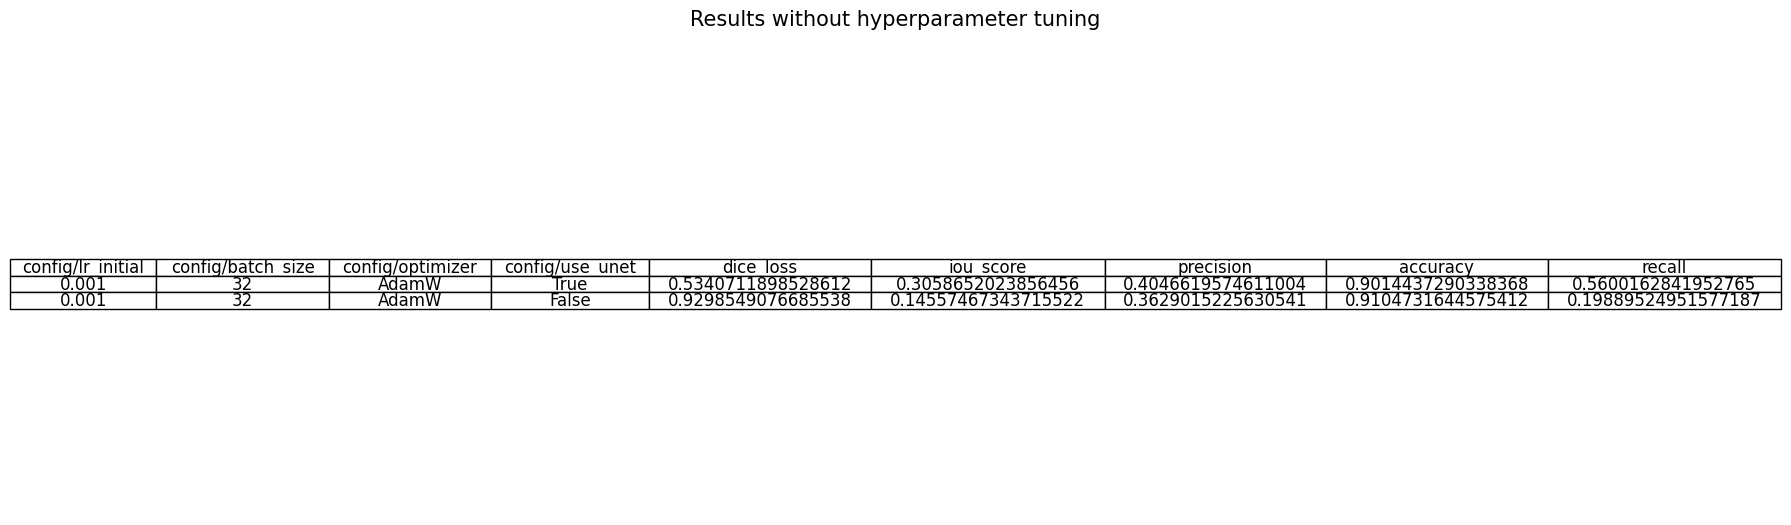

/tmp/ipykernel_2619187/4143206056.py:251: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics = df_metrics.applymap(lambda x: round(x, 4) if isinstance(x, (int, float)) else x)


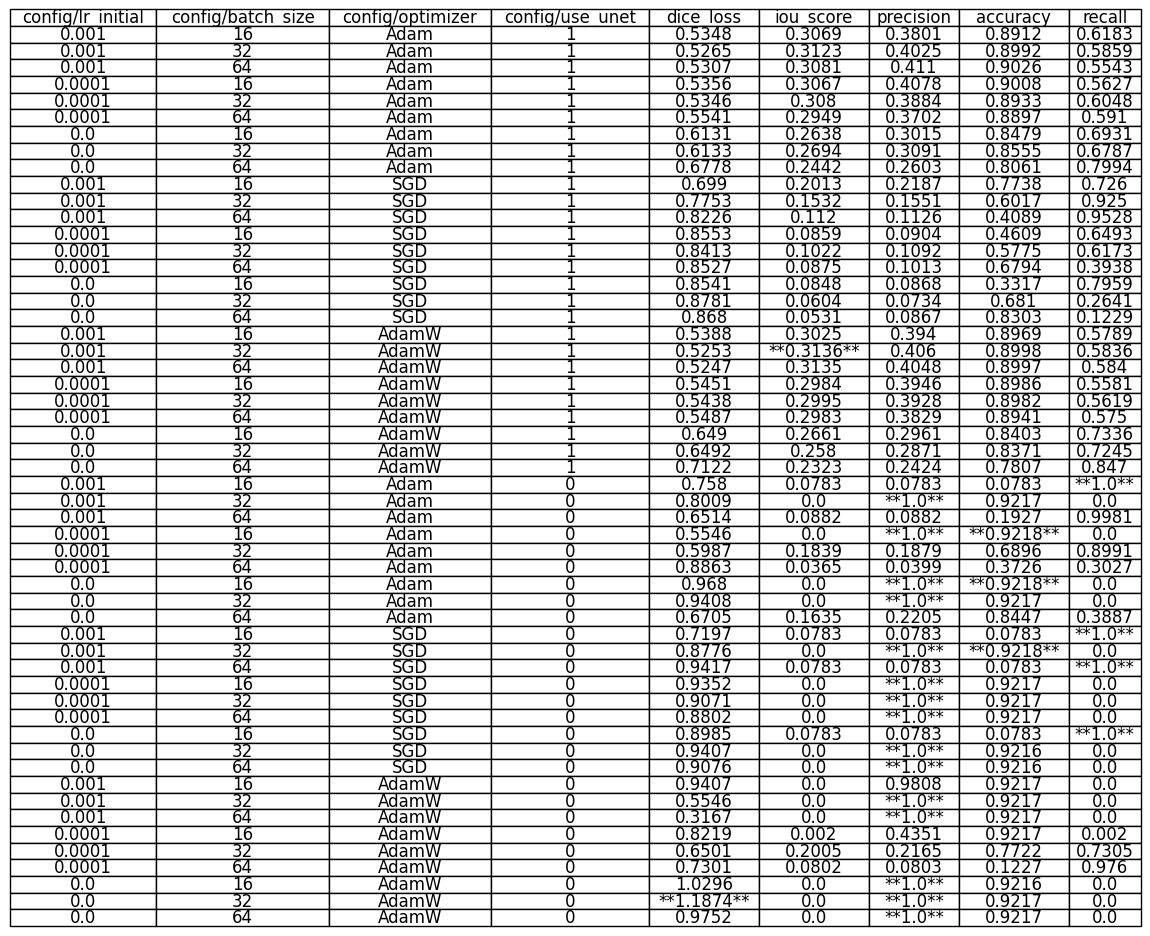

In [2]:
best_config = {'max_t': 20, 'num_samples': 1, 'epochs': 100, 'use_unet': True, 'train_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_train'), 'val_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_val'), 'test_data_dir': PosixPath('/home/lt/kamaro/lenameyerlandrut/segmentation_dataset_test'), 'batch_size': 32, 'lr_initial': 0.001, 'optimizer': 'AdamW'}
best_config["augmentations"] = A.Compose(AUGMENTATIONS)
train_model(best_config)


Epoch #1 (learning rate - 1.00e-03)


/home/lt/kamaro/lenameyerlandrut/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:651: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(



Epoch #2 (learning rate - 1.00e-03)

Epoch #3 (learning rate - 1.00e-03)

Epoch #4 (learning rate - 1.00e-03)

Epoch #5 (learning rate - 1.00e-03)

Epoch #6 (learning rate - 1.00e-03)

Epoch #7 (learning rate - 1.00e-03)

Epoch #8 (learning rate - 1.00e-04)

Epoch #9 (learning rate - 1.00e-04)

Epoch #10 (learning rate - 1.00e-04)

Epoch #11 (learning rate - 1.00e-04)

Epoch #12 (learning rate - 1.00e-04)

Epoch #13 (learning rate - 1.00e-04)

Epoch #14 (learning rate - 1.00e-05)

Epoch #15 (learning rate - 1.00e-05)

Epoch #16 (learning rate - 1.00e-05)

Epoch #17 (learning rate - 1.00e-05)

Epoch #18 (learning rate - 1.00e-05)

Epoch #19 (learning rate - 1.00e-05)

Epoch #20 (learning rate - 1.00e-05)


In [ ]:
def evaluate_unet(config, model_path: str):
    device = DEVICE_CUDA
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        activation=ACTIVATION,
        classes=1,
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    test_dataset = BuildingSegmentation(
        Path(config["test_data_dir"]).joinpath("imgs"),
        Path(config["test_data_dir"]).joinpath("masks"),
        augmentation=None,
        preprocessing=get_preprocessing(preprocessing_fn),
    )

    test_loader = DataLoader(
        test_dataset, batch_size=config["batch_size"], shuffle=False
    )

    
    loss = smp_utils.losses.DiceLoss()
    metrics = [
        smp_utils.metrics.IoU(threshold=0.5),
        smp_utils.metrics.Accuracy(threshold=0.5),
        smp_utils.metrics.Precision(threshold=0.5),
        smp_utils.metrics.Recall(threshold=0.5),
        smp_utils.metrics.Fscore(threshold=0.5),
    ]

    test_epoch = smp_utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=device,
        verbose=True,
    )

    logs = test_epoch.run(test_loader)
    print("Test results:", logs)

                
evaluate_unet(best_config, "weights_lr_0.001_bs_32_optimizer_AdamW_unet/best.pth", "runs")